In [119]:
import torch
from diffusers import DDPMPipeline, DDPMScheduler
import matplotlib.pyplot as plt
import torchvision.transforms as T
import numpy as np
import random
from particles import state_space_models as ssm
import particles

import os
from torchvision import datasets, transforms
from torch import nn 
from scipy.stats import multivariate_normal

In [120]:
seed = 123

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [202]:
device = "cuda" if torch.cuda.is_available() else "cpu"

pipe = DDPMPipeline.from_pretrained("1aurent/ddpm-mnist").to(device)
pipe.unet.eval()

from diffusers import DDPMPipeline

# pipe = DDPMPipeline.from_pretrained('dvgodoy/ddpm-cifar10-32-mnist').to(device)


Loading pipeline components...: 100%|██████████| 2/2 [00:00<00:00, 84.19it/s]


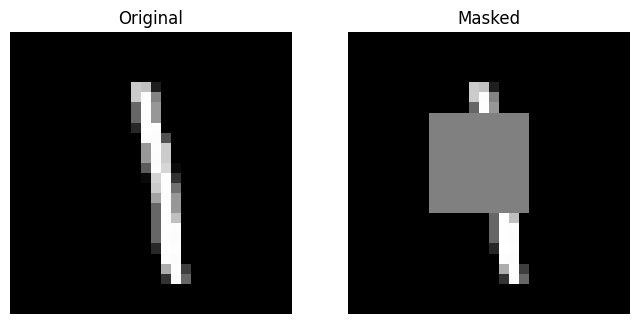

In [203]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# --- Load MNIST ---
mnist = datasets.MNIST(root="./data", train=False, download=True, transform=transforms.ToTensor())
x0, label = mnist[31]
x0 = x0.numpy().squeeze()

# --- Mask ---
#test
x0 = x0 * 2.0 - 1.0   # [0,1] -> [-1,1]
#x0 = x0 * 255

mask = np.ones_like(x0)
mask[8:18,8:18] = 0
masked_img = x0 * mask #+ (mask - 1)
#masked_img = masked_img * 2.0 - 1.0 

# --- Flatten for SMC ---
x0_flat = x0.flatten()
mask_flat = mask.flatten().astype(bool)
obs_idx = np.where(mask_flat)[0]
miss_idx = np.where(~mask_flat)[0]
y_obs = x0_flat[obs_idx]
dx = x0_flat.size
dy = len(obs_idx)

# test
def to_img(x):
    return (x + 1.0) / 2

# --- Display original and masked ---
fig, ax = plt.subplots(1,2, figsize=(8,4))
# ax[0].imshow(x0, cmap="gray"); ax[0].set_title("Original"); ax[0].axis("off")
# ax[1].imshow(masked_img, cmap="gray"); ax[1].set_title("Masked"); ax[1].axis("off")
ax[0].imshow(to_img(x0), cmap="gray"); ax[0].set_title("Original"); ax[0].axis("off")
ax[1].imshow(to_img(masked_img), cmap="gray"); ax[1].set_title("Masked"); ax[1].axis("off")
plt.show()

In [157]:
masked_img[10, 10]

0.0

In [176]:
def to_img(x):
    return (x + 1.0) / 2.0

ax[0].imshow(to_img(x0), cmap="gray")
ax[1].imshow(to_img(masked_img), cmap="gray")

In [177]:
# # --- Load your trained SmallUNet ---
# class ImprovedUNet(nn.Module):
#     def __init__(self, in_ch=1, base_ch=64):
#         super().__init__()
#         # Encoder
#         self.enc1 = nn.Sequential(nn.Conv2d(in_ch, base_ch, 3, 1, 1), nn.ReLU())
#         self.enc2 = nn.Sequential(nn.Conv2d(base_ch, base_ch*2, 3, 2, 1), nn.ReLU())
#         self.enc3 = nn.Sequential(nn.Conv2d(base_ch*2, base_ch*2, 3, 1, 1), nn.ReLU())
#         # Decoder
#         self.dec1 = nn.Sequential(nn.ConvTranspose2d(base_ch*2, base_ch*2, 4, 2, 1), nn.ReLU())
#         self.dec2 = nn.Sequential(nn.Conv2d(base_ch*2, base_ch, 3, 1, 1), nn.ReLU())
#         self.out = nn.Conv2d(base_ch, in_ch, 3, 1, 1)

#     def forward(self, x, t):
#         h = self.enc1(x)
#         h = self.enc2(h)
#         h = self.enc3(h)
#         h = self.dec1(h)
#         h = self.dec2(h)
#         return self.out(h) 
    

# unet = ImprovedUNet().to(device)
# unet.load_state_dict(torch.load("models/ddpm_mnist_100_100e_imp_low_beta.pt", map_location=device))
# unet.eval()

In [204]:
# --- Forward schedule ---
num_timesteps = 100
beta_start, beta_end = 1e-4, 0.01
betas = np.linspace(beta_start, beta_end, num_timesteps)
alphas = 1.0 - betas
alpha_bars = np.cumprod(alphas)
sigmas = np.sqrt(betas)

In [ ]:
import torch
import numpy as np
from diffusers import DDPMPipeline

device = "cuda" if torch.cuda.is_available() else "cpu"

pipe = DDPMPipeline.from_pretrained("1aurent/ddpm-mnist")
#print('new')
#pipe = DDPMPipeline.from_pretrained('balakrish181/ddpm-class-mnist-28')
pipe = pipe.to(device)

unet = pipe.unet              # modèle eps_theta
scheduler = pipe.scheduler    # scheduler DDPM

# Scheduler arrays (torch tensors)
betas = scheduler.betas.to(device)                 # (T,)
alphas = 1.0 - betas
alpha_bars = torch.cumprod(alphas, dim=0)          # \bar alpha_t
sigmas = torch.sqrt(betas)                         # proxy sigma_t (comme dans ta codebase)
#sigmas = torch.zeros_like(sigmas)  

# Si tu veux rester en numpy pour ta codebase :
alpha_bars_np = alpha_bars.detach().cpu().numpy()
alpha_np = alphas.detach().cpu().numpy()
sigmas_np = sigmas.detach().cpu().numpy()


Loading pipeline components...: 100%|██████████| 2/2 [00:00<00:00, 59.50it/s]


In [180]:
import torch.nn as nn

class DiffusersEpsWrapper(nn.Module):
    def __init__(self, unet):
        super().__init__()
        self.unet = unet

    def forward(self, x, t):
        out = self.unet(x, t)
        return out.sample if hasattr(out, "sample") else out

eps_model = DiffusersEpsWrapper(unet).to(device).eval()


In [181]:
# # --- Backward FK ---
# class NoiselessBackwardFK:
#     def __init__(self, y, obs_idx, miss_idx, alpha_bars, sigmas, model, dx):
#         self.y = y
#         self.obs_idx = obs_idx
#         self.miss_idx = miss_idx
#         self.dy = len(obs_idx)
#         self.alpha_bars = alpha_bars
#         self.sigmas = sigmas
#         self.model = model
#         self.dx = dx
#         self.nsteps = len(alpha_bars) - 1

#     @torch.no_grad()
#     def chi(self, x, t):
#         x = np.atleast_2d(x)
#         N = x.shape[0]
#         img_size = int(np.sqrt(self.dx))
#         x_img = x.reshape(N, 1, img_size, img_size)
#         x_tensor = torch.tensor(x_img, dtype=torch.float32, device=device)

#         t_model = scheduler.timesteps[t]   # pas t directement
#         t_tensor = torch.full((N,), t_model, device=device, dtype=torch.long)

#         #t_tensor = torch.full((N,), t, device=device, dtype=torch.long)
#         eps = self.model(x_tensor, t_tensor).cpu().numpy().reshape(N, -1)
#         alpha_bar_t = np.maximum(self.alpha_bars[t], 1e-5)
#         #print(eps[0, 0])
        
#         chi = x / np.sqrt(alpha_bar_t) - np.sqrt(1 - alpha_bar_t) * eps
#         #print("t", t, "alpha_bar", self.alpha_bars[t])
#         #print("x_minmax", x.min(), x.max())
#         #print("eps_minmax", eps.min(), eps.max())


#         return chi

#         #return chi

#     def m(self, x_next, t):
#         chi = self.chi(x_next, t + 1)
#         sigma2 = self.sigmas[t + 1]**2
#         alpha_bar = self.alpha_bars[t + 1]
#         Kt = sigma2 / (sigma2 + 1 - alpha_bar)
#         mean = chi.copy()
#         mean[:, self.obs_idx] = Kt * np.sqrt(alpha_bar) * self.y + (1 - Kt) * chi[:, self.obs_idx]
#         return mean

#     def M0(self, N):
#         particles = np.zeros((N, self.dx))
#         alpha_n = self.alpha_bars[-1]
#         sigma_n = self.sigmas[-1]
#         Kn = sigma_n**2 / (sigma_n**2 + 1 - alpha_n)
#         mean_obs = Kn * np.sqrt(alpha_n) * self.y
#         cov_obs = (((1 - alpha_n) * Kn)**2) * np.eye(self.dy)
#         # manque carré (fix but a verif)
#         particles[:, self.obs_idx] = np.random.multivariate_normal(mean_obs, cov_obs, size=N)
#         particles[:, self.miss_idx] = np.random.randn(N, len(self.miss_idx))
#         return particles

#     def M(self, s, xp):
#         mean = self.m(xp, s)
#         alpha_s = self.alpha_bars[s]
#         sigma_sp1 = self.sigmas[s + 1]
#         Ks = sigma_sp1**2 / (sigma_sp1**2 + 1 - alpha_s)
#         cov_obs = (1 - alpha_s) * Ks * np.eye(self.dy)
#         new_obs = np.array([np.random.multivariate_normal(mean=m[self.obs_idx], cov=cov_obs) for m in mean])
#         xp_new = xp.copy()
#         xp_new[:, self.obs_idx] = new_obs

#         # test
#         xp_new[:, self.miss_idx] = (
#                 mean[:, self.miss_idx]
#                 + sigma_sp1 * np.random.randn(len(xp_new), len(self.miss_idx))
#             )
        
#         return xp_new


# # --- PseudoSMC with snapshot saving ---
# class PseudoSMC:
#     def __init__(self, fk, N=5, snapshot_dir="./manual_smc_res"):
#         self.fk = fk
#         self.N = N
#         self.snapshot_dir = snapshot_dir
#         os.makedirs(snapshot_dir, exist_ok=True)

#     def compute_weights(self, particles, s):
#         mean = self.fk.m(particles, s)
#         cov = self.fk.sigmas[s + 1]**2 + 1 - self.fk.alpha_bars[s]
#         log_w = np.zeros(self.N)
#         for i in range(self.N):
#             diff = np.sqrt(self.fk.alpha_bars[s]) * self.fk.y - mean[i, self.fk.obs_idx]
#             # mauvais poids
#             log_w[i] = -0.5 * diff @ diff / cov - 0.5 * self.fk.dy * np.log(2 * np.pi * cov)
#         log_w -= np.max(log_w)
#         w = np.exp(log_w)
#         if np.sum(w) == 0 or np.isnan(np.sum(w)):
#             return np.ones(self.N) / self.N
#         return w / np.sum(w)

#     def resample(self, particles, weights):
#         idx = np.random.choice(self.N, self.N, replace=True, p=weights)
#         return particles[idx]

#     def run(self, snapshot_every=5):
#         particles = self.fk.M0(self.N)
#         #start = 200
#         for s in reversed(range(self.fk.nsteps)):
#         #for s in reversed(range(start)):
#             w = self.compute_weights(particles, s)
#             particles = self.resample(particles, w)
#             #print(particles[0, 0])
#             particles = self.fk.M(s, particles)
#             if s % snapshot_every == 0:
#                 is_valid = np.all(np.isfinite(particles), axis=1)
#                 n_valid = np.sum(is_valid)
#                 n_degen = self.N - n_valid

#                 if n_valid > 0:
#                     recon = particles[is_valid].mean(axis=0).reshape(28, 28)
#                 else:
#                     recon = np.zeros((28,28))

#                 filename = os.path.join(self.snapshot_dir, f"step_{s:04d}.png")
#                 plt.imsave(filename, recon, cmap="gray")
#                 print(f"Step {s}: {n_valid} valid, {n_degen} degenerate particles")
#                 plt.imsave(os.path.join(self.snapshot_dir, f"step_{s:04d}.png"), recon, cmap="gray")
#         return particles

# # --- Run full SMC ---
# fk = NoiselessBackwardFK(y=y_obs, obs_idx=obs_idx, miss_idx=miss_idx,
#                           alpha_bars=alpha_bars_np, sigmas=sigmas_np,
#                           model=eps_model, dx=dx)

# smc = PseudoSMC(fk, N=20)
# particles_final = smc.run(snapshot_every=5)

# # --- Show final reconstruction ---
# recon = particles_final.mean(axis=0).reshape(28,28)
# recon = particles_final[0].reshape(28,28)
# recon = to_img(recon)
# plt.imshow(recon, cmap="gray")
# plt.title("Final inpainted image")
# plt.axis("off")
# plt.show()

eps 0, 0 0.13178146
mean 0, 0 -12.84279379549888
log_w [-881078.75953809 -831191.83434129 -759666.68009878 -755737.29869673
 -752161.54495403]
-0.00011127789472245948
eps 0, 0 0.008723473
eps 0, 0 0.17173298
mean 0, 0 -22.493143336031455
log_w [-1498325.58889446 -1534543.64420831 -1498884.22890152 -1505131.86964841
 -1542060.02954075]
0.02738383865986966
eps 0, 0 0.17173298
eps 0, 0 0.4249673
mean 0, 0 -57.242093185268615
log_w [-1500144.28232116 -1480665.93665934 -1524109.44606769 -1485418.37285027
 -1469719.41819874]
0.04032429172854379
eps 0, 0 0.39381847
eps 0, 0 0.55713487
mean 0, 0 -80.66890066719715
log_w [-1472187.83916488 -1454379.60850296 -1488946.53712363 -1474486.25333505
 -1463641.26798478]
0.04882915931969212
eps 0, 0 0.62692446
Step 995: 5 valid, 0 degenerate particles
eps 0, 0 0.8064128
mean 0, 0 -115.27307281010229
log_w [-1474832.78442504 -1416758.52979397 -1469474.0172391  -1451194.32318993
 -1449601.60028715]
0.04484167394941497
eps 0, 0 0.7964832
eps 0, 0 0.9555695

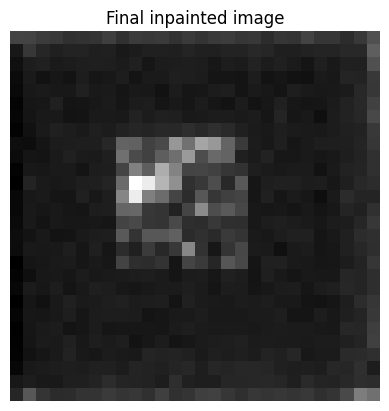

In [226]:
# --- Backward FK ---
class NoiselessBackwardFK:
    def __init__(self, y, obs_idx, miss_idx, alpha_bars, alpha, sigmas, model, dx, start):
        self.y = y
        self.obs_idx = obs_idx
        self.miss_idx = miss_idx
        self.dy = len(obs_idx)
        self.alpha_bars = alpha_bars
        self.alpha = alpha
        self.sigmas = sigmas
        self.model = model
        self.dx = dx
        self.nsteps = len(alpha_bars) - 1
        self.start = self.nsteps if start is None else start
        # self.nsteps = len(alpha_bars) # pk - 1 ??

    @torch.no_grad()
    def chi(self, x, t):
        x = np.atleast_2d(x)
        N = x.shape[0]
        img_size = int(np.sqrt(self.dx))
        x_img = x.reshape(N, 1, img_size, img_size)
        # pb
        #x_img = x.reshape(N, 1, img_size, img_size)
        #x_img = np.repeat(x_img, 3, axis=1)  # -> [N, 3, H, W]

        x_tensor = torch.tensor(x_img, dtype=torch.float32, device=device)

        t_model = scheduler.timesteps[t]   # pas t directement
        t_tensor = torch.full((N,), t_model, device=device, dtype=torch.long)

        eps = self.model(x_tensor, t_tensor).cpu().numpy().reshape(N, -1)
        # alpha_bar_t = np.maximum(self.alpha_bars[t], 1e-5)
        alpha_bar_t = self.alpha_bars[t]
        print('eps 0, 0', eps[0, 0])
        
        chi = x / np.sqrt(alpha_bar_t) - np.sqrt(1 - alpha_bar_t) * eps
        chi = (x - np.sqrt(1 - alpha_bar_t) * eps) / np.sqrt(alpha_bar_t)

        return chi


    # def m(self, x_next, t):
    #     chi = self.chi(x_next, t + 1)
    #     sigma_tp1_2 = self.sigmas[t + 1]**2
    #     alpha_bar_t = self.alpha_bars[t]
    #     alpha = self.alpha[t]
    #     Kt = sigma_tp1_2 / (sigma_tp1_2 + 1 - alpha_bar_t)
    #     # inconsistent paper
    #     # fix : 
    #     # Kt = sigma_tp1_2 / (sigma_tp1_2 + 1 - alpha)

    #     mean = chi.copy()
    #     mean[:, self.obs_idx] = Kt * np.sqrt(alpha_bar_t) * self.y + (1 - Kt) * chi[:, self.obs_idx]
    #     return mean
    
    def m(self, x_next, t):
        # x_next = x_{t+1}
        x0_hat = self.chi(x_next, t + 1)

        abar_t   = self.alpha_bars[t]
        abar_tp1 = self.alpha_bars[t + 1]
        sigma2   = self.sigmas[t + 1]**2

        denom = np.sqrt(max(1e-12, 1.0 - abar_tp1))
        c1 = np.sqrt(abar_t)
        c2 = np.sqrt(max(0.0, 1.0 - abar_t - sigma2))

        return c1 * x0_hat + c2 * (x_next - np.sqrt(abar_tp1) * x0_hat) / denom


    def M0(self, N):
        particles = np.zeros((N, self.dx))
        alpha_bar_n = self.alpha_bars[-1]
        alpha_n = self.alpha[-1]
        # possibiliy but also
        sigma_np1 = self.sigmas[-1] #les sigma sont indexe chelou

        # c'est relou mais si commence au milieu il faut changer
        alpha_bar_n = self.alpha_bars[self.start]
        alpha_n = self.alpha[self.start]
        sigma_np1 = self.sigmas[self.start]

        # sigma_np1 = np.sqrt(1 - alpha_bar_n)
        Kn = sigma_np1**2 / (sigma_np1**2 + 1 - alpha_bar_n)
        # Kn = sigma_np1**2 / (sigma_np1**2 + 1 - alpha_n) # vraie formule
        # print("Kn M0", Kn)
        # print(sigma_np1**2 / (sigma_np1**2 + 1 - alpha_bar_n))

        mean_obs = Kn * np.sqrt(alpha_bar_n) * self.y
        cov_obs = (((1 - alpha_bar_n) * Kn)**2) * np.eye(self.dy) # attention carré
        particles[:, self.obs_idx] = np.random.multivariate_normal(mean_obs, cov_obs, size=N)
        particles[:, self.miss_idx] = np.random.randn(N, len(self.miss_idx))
        return particles

    def M(self, s, xp):
        mean = self.m(xp, s)
        alpha_bar_s = self.alpha_bars[s]
        alpha_s = self.alpha[s]
        sigma_sp1 = self.sigmas[s + 1]
        # Ks = sigma_sp1**2 / (sigma_sp1**2 + 1 - alpha_s)
        Ks = sigma_sp1**2 / (sigma_sp1**2 + 1 - alpha_bar_s)
        cov_obs = (1 - alpha_s) * Ks * np.eye(self.dy) # ok pour carré
        # MAIS cette variance marche que pour la partie observée 
        new_obs = np.array([np.random.multivariate_normal(mean=m[self.obs_idx], cov=cov_obs) for m in mean])
        xp_new = xp.copy()
        xp_new[:, self.obs_idx] = new_obs
        # test (quick fix c'est moche mais normalement c'est le bon truc)
        xp_new[:, self.miss_idx] = (
                mean[:, self.miss_idx]
                + sigma_sp1 * np.random.randn(len(xp_new), len(self.miss_idx))
            )
        return xp_new

# Ok ca a l'air good au dessus (à un off by one index près pcq on fait self.m(xp, s) et s + 1 mais on verra ca)


# --- PseudoSMC with snapshot saving ---
class PseudoSMC:
    def __init__(self, fk, N=5, start=None, snapshot_dir="./manual_smc_res"):
        self.fk = fk
        self.N = N
        self.snapshot_dir = snapshot_dir
        self.start = self.fk.start
        os.makedirs(snapshot_dir, exist_ok=True)

    def compute_weights(self, particles, s):
        #mean = self.fk.m(particles, s)
        mean = self.fk.chi(particles, s + 1) # .clip(-1, 1) marche pas
        print('mean 0, 0', mean[0, 0])
        cov_num = self.fk.sigmas[s + 1]**2 + 1 - self.fk.alpha_bars[s] # ok
        cov_denom = 1 - self.fk.alpha_bars[s + 1]  
        cov_denom = max(cov_denom, 1e-4)

        log_w = np.zeros(self.N)
        if s == (self.start - 1):
            for i in range(self.N):
                alpha_bars_n = self.fk.alpha_bars[self.start]
                log_w[i] = multivariate_normal.logpdf(np.sqrt(alpha_bars_n) * self.fk.y, mean=mean[i, self.fk.obs_idx], cov=2 - alpha_bars_n)
        else:
            for i in range(self.N):
                log_w[i] = (
                    multivariate_normal.logpdf(np.sqrt(self.fk.alpha_bars[s]) * self.fk.y, mean=mean[i, self.fk.obs_idx], cov=cov_num)
                    - multivariate_normal.logpdf(np.sqrt(self.fk.alpha_bars[s + 1]) * self.fk.y, mean=particles[i, self.fk.obs_idx], cov=cov_denom)
                )
        print('log_w', log_w)
        log_w -= np.max(log_w)
        w = np.exp(log_w)
        if np.sum(w) == 0 or np.isnan(np.sum(w)):
            return np.ones(self.N) / self.N
        return w / np.sum(w)

    def resample(self, particles, weights):
        idx = np.random.choice(self.N, self.N, replace=True, p=weights)
        return particles[idx]

    def run(self, snapshot_every=5):
        particles = self.fk.M0(self.N)
        for s in reversed(range(self.start)):
            w = self.compute_weights(particles, s)
            particles = self.resample(particles, w)
            print(particles[0, 0])
            particles = self.fk.M(s, particles)
            if s % snapshot_every == 0:
                is_valid = np.all(np.isfinite(particles), axis=1)
                n_valid = np.sum(is_valid)
                n_degen = self.N - n_valid

                if n_valid > 0:
                    recon = particles[is_valid].mean(axis=0).reshape(28, 28)
                else:
                    recon = np.zeros((28,28))

                filename = os.path.join(self.snapshot_dir, f"step_{s:04d}.png")
                plt.imsave(filename, to_img(recon), cmap="gray")
                print(f"Step {s}: {n_valid} valid, {n_degen} degenerate particles")
                plt.imsave(os.path.join(self.snapshot_dir, f"step_{s:04d}.png"), recon, cmap="gray")
        return particles

# --- Run full SMC ---
fk = NoiselessBackwardFK(y=y_obs, obs_idx=obs_idx, miss_idx=miss_idx,
                          alpha_bars=alpha_bars_np, alpha=alpha_np, sigmas=sigmas_np,
                          model=eps_model, dx=dx, start=None)

smc = PseudoSMC(fk, N=5)
particles_final = smc.run(snapshot_every=5)

# --- Show final reconstruction ---
recon = particles_final.mean(axis=0).reshape(28,28)
recon = particles_final[0].reshape(28,28)
recon = to_img(recon)
plt.imshow(recon, cmap="gray")
plt.title("Final inpainted image")
plt.axis("off")
plt.show()

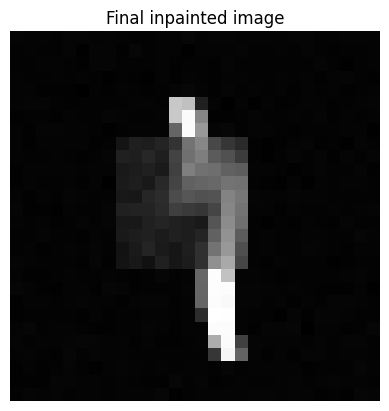

In [ ]:
recon = particles_final[3].reshape(28,28)
recon = particles_final[3].reshape(28,28).copy()
plt.imshow(to_img(recon), cmap="gray")
plt.title("Final inpainted image")
plt.axis("off")
plt.show()

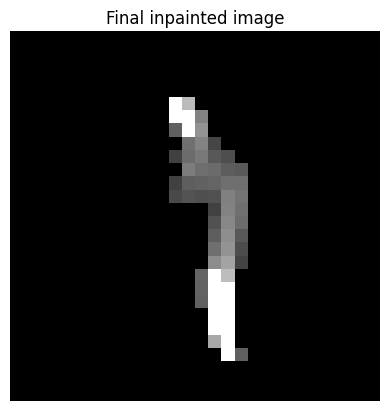

In [ ]:
recon[recon <= -0.5] = -1.0
recon[recon >= 0.5] = 1.0
plt.imshow(to_img(recon), cmap="gray")
plt.title("Final inpainted image")
plt.axis("off")
plt.show()

In [214]:
import torch
import numpy as np
from diffusers import DDPMPipeline

device = "cuda" if torch.cuda.is_available() else "cpu"

pipe = DDPMPipeline.from_pretrained("1aurent/ddpm-mnist")
pipe = pipe.to(device)

unet = pipe.unet              # modèle eps_theta
scheduler = pipe.scheduler    # scheduler DDPM

# Scheduler arrays (torch tensors)
betas = scheduler.betas.to(device)                 # (T,)
alphas = 1.0 - betas
alpha_bars = torch.cumprod(alphas, dim=0)          # \bar alpha_t
sigmas = torch.sqrt(betas)                         # proxy sigma_t (comme dans ta codebase)
sigmas = torch.zeros_like(sigmas)  

# Si tu veux rester en numpy pour ta codebase :
alpha_bars_np = alpha_bars.detach().cpu().numpy()
alpha_np = alphas.detach().cpu().numpy()
sigmas_np = sigmas.detach().cpu().numpy()


Loading pipeline components...: 100%|██████████| 2/2 [00:00<00:00, 37.26it/s]


Loading pipeline components...: 100%|██████████| 2/2 [00:00<00:00, 65.03it/s]


Sample :


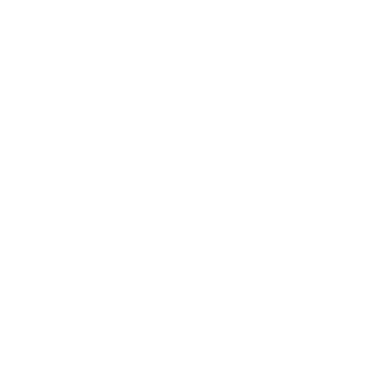

In [222]:
# as a sanity check we will regularly sample from the diffusion model

import torch
import numpy as np
from diffusers import DDPMPipeline

device = "cuda" if torch.cuda.is_available() else "cpu"

pipe = DDPMPipeline.from_pretrained("1aurent/ddpm-mnist")
pipe = pipe.to(device)

unet = pipe.unet              # modèle eps_theta
scheduler = pipe.scheduler    # scheduler DDPM

# Scheduler arrays (torch tensors)
betas = scheduler.betas.to(device)                 # (T,)
alphas = 1.0 - betas
alpha_bars = torch.cumprod(alphas, dim=0)          # \bar alpha_t
sigmas = torch.sqrt(betas)                         # proxy sigma_t (comme dans ta codebase)
#sigmas = torch.zeros_like(sigmas)  

# Si tu veux rester en numpy pour ta codebase :
alpha_bars_np = alpha_bars.detach().cpu().numpy()
alpha_np = alphas.detach().cpu().numpy()
sigmas_np = sigmas.detach().cpu().numpy()

import torchvision
import matplotlib.pyplot as plt

model = DiffusersEpsWrapper(unet).to(device).eval()
num_samples = 4
img_size = 28
x = torch.randn((num_samples, 1, img_size, img_size), device=device)
for t in reversed(range(scheduler.num_train_timesteps)):
    t_tensor = torch.full((num_samples,), scheduler.timesteps[t], device=device, dtype=torch.long)
    with torch.no_grad():
        eps = model(x, t_tensor)
    alpha_t = alphas[t]
    alpha_bar_t = alpha_bars[t]
    sigma_t = sigmas[t]
    #x = (1 / torch.sqrt(alpha_t)) * (x - (1 - alpha_t) / torch.sqrt(1 - alpha_bar_t) * eps)
    x = x / torch.sqrt(alpha_bar_t) - torch.sqrt(1 - alpha_bar_t) * eps
    if t > 0:
        z = torch.randn_like(x)
        x = x + sigma_t * z

print("Sample :", )
plt.imshow(x[0, 0].cpu(), cmap="gray")
plt.axis("off")
plt.show()

Loading pipeline components...: 100%|██████████| 2/2 [00:00<00:00, 71.22it/s]


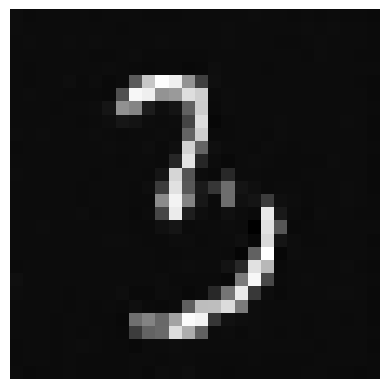

In [224]:
import torch
import matplotlib.pyplot as plt
from diffusers import DDPMPipeline

device = "cuda" if torch.cuda.is_available() else "cpu"
pipe = DDPMPipeline.from_pretrained("1aurent/ddpm-mnist").to(device)

unet = pipe.unet.eval()
scheduler = pipe.scheduler

betas = scheduler.betas.to(device)
alphas = 1.0 - betas
alpha_bars = torch.cumprod(alphas, dim=0)

num_samples = 4
x = torch.randn((num_samples, 1, 28, 28), device=device)

T = scheduler.num_train_timesteps

with torch.no_grad():
    for t in reversed(range(T)):
        t_tensor = torch.full((num_samples,), t, device=device, dtype=torch.long)

        # diffusers unet renvoie un objet avec .sample
        eps = unet(x, t_tensor).sample

        beta_t = betas[t]
        alpha_t = alphas[t]
        alpha_bar_t = alpha_bars[t]

        # mu_theta
        x = (1.0 / torch.sqrt(alpha_t)) * (x - (beta_t / torch.sqrt(1.0 - alpha_bar_t)) * eps)

        if t > 0:
            z = torch.randn_like(x)
            x = x + torch.sqrt(beta_t) * z

img = x[0, 0].detach().cpu()
plt.imshow(img, cmap="gray")
plt.axis("off")
plt.show()
